# Time Series Forecasting - Temperature

In this notebook we will create a model to forecast temperature and comment it, data cleaning and handling were made in the ETL notebook.

The purpose here is to implement a simple neural network using LSTM, GRU and CNN(1d), learn how to use it and compare performance.

In [38]:
import zipfile
import urllib

import tensorflow as tf
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

from functions import *

# Setting Seaborn Theme
sns.set_theme(style="whitegrid", font_scale=1.4)

plt.rcParams["figure.figsize"] = (15,9)

In [10]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)

In [ ]:
# Getting Initial Files
initial_files = os.listdir()

# Getting Files and files path
files_path = get_data('brasilia',2011,2020)

# Creating dataframe from all csv files
df = create_dataframe(files_path)

# Deleting/Removing Files
files_list = os.listdir()

for name in files_list:

    if name not in initial_files:

        if os.path.isdir(name):
            shutil.rmtree(name, ignore_errors=True)
        
        elif os.path.isfile(name):
            os.remove(name)

# Saving dataframe
df.to_csv(f"{city}_temperature_data.csv")

Here we will load preprocessed data ( cleaned and missing values handled)

In [2]:
# Reading cleaned dataframe
df = pd.read_csv('brasilia_temperature_data.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime',inplace=True,drop=True)

# Getting a dataframe with only temperature
temperature_df = df['Temperature']

First we will visualize data only for 2018-2020 in order to avoid a noisy chart.

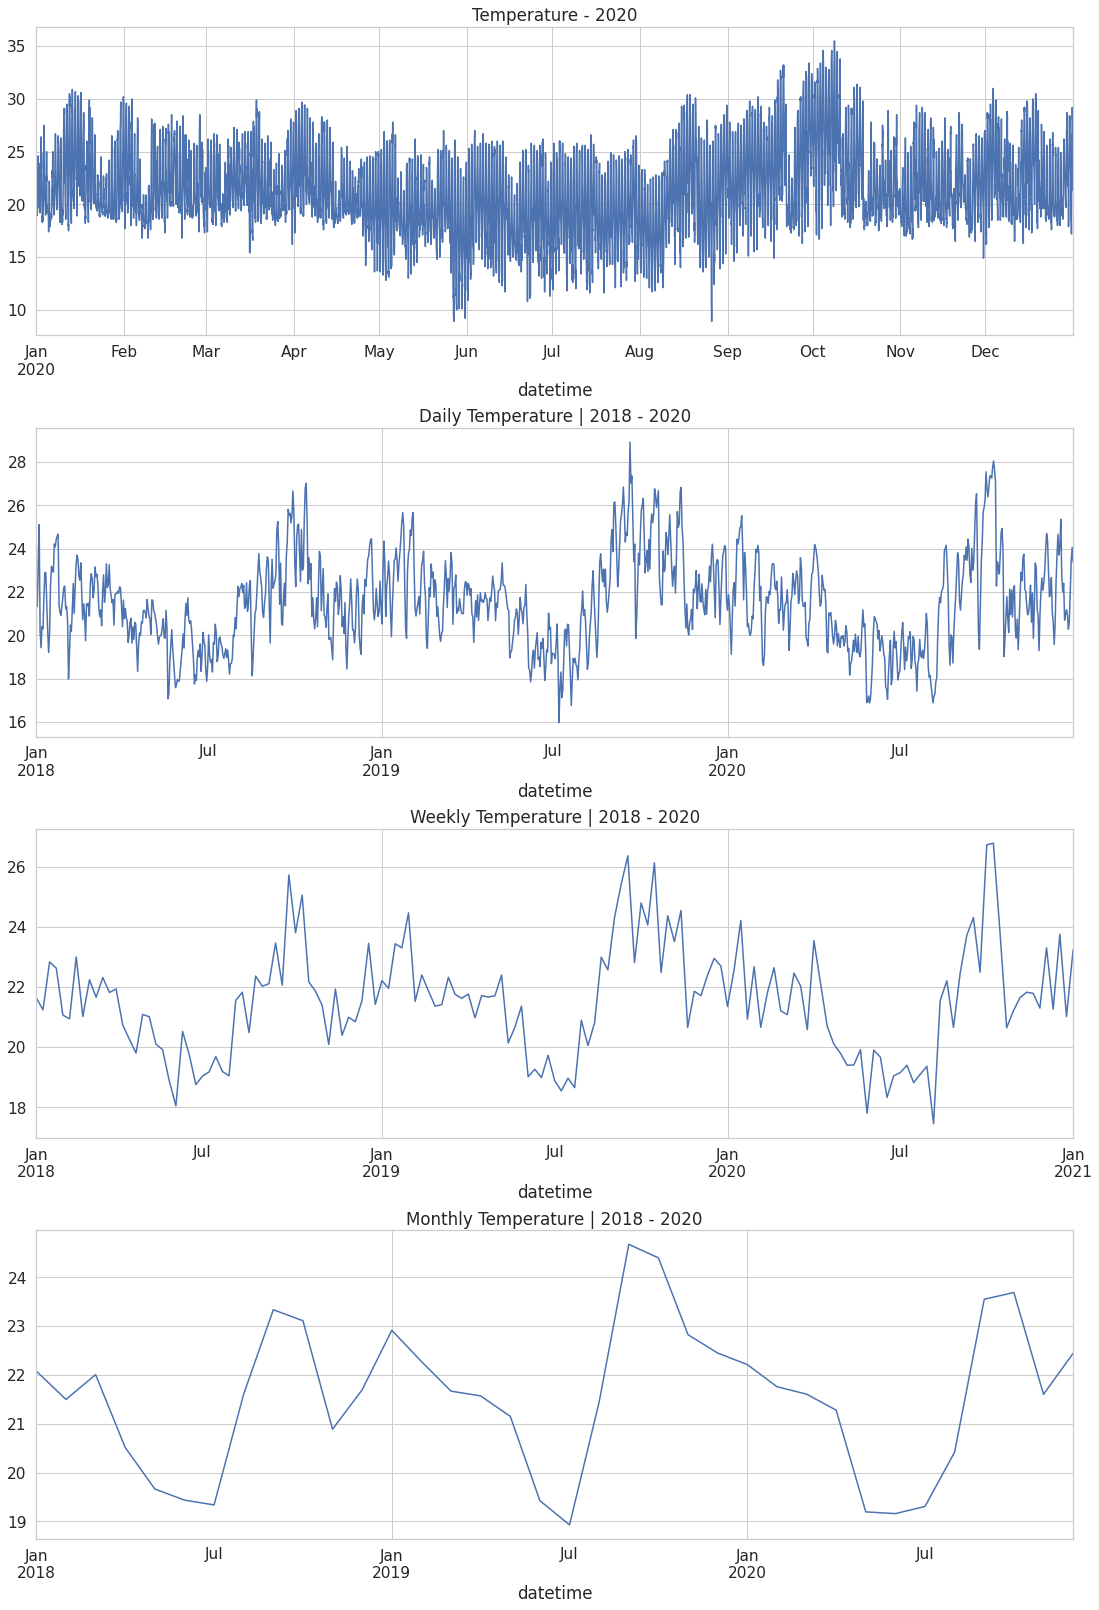

In [20]:
plt.rcParams["figure.figsize"] = (18,15)
fig1, axs = plt.subplots(nrows=4, ncols=1)

axs[0] = temperature_df['2020':].plot(ax = axs[0],title='Temperature - 2020')
axs[1] = temperature_df['2018':].resample('D').mean().plot(ax = axs[1], title='Daily Temperature | 2018 - 2020')
axs[2] = temperature_df['2018':].resample('W').mean().plot(ax = axs[2], title='Weekly Temperature | 2018 - 2020')
axs[3] = temperature_df['2018':].resample('M').mean().plot(ax = axs[3], title='Monthly Temperature | 2018 - 2020')

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.5, 
                    wspace=0.1, 
                    hspace=0.3)

plt.show()

We were using only 2018 to 2020 data but we can see some sort of seasonality , which is good to use prophet, but lets see how it will behave with LSTM.

In this LSTM/GRU/CNN it will be used sliding windows as input, default will be 5 hours to predict the next hour.

In [29]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)

def train_test_val_split(df, window_size=5):
    X, y = df_to_X_y(temperature_df, window_size)

    total_len = len(X)
    test_val_len = int(total_len * 0.10)
    train_len = total_len - (2*test_val_len)

    X_train, y_train = X[:train_len], y[:train_len]
    X_val, y_val = X[train_len:train_len + test_val_len], y[train_len:train_len + test_val_len]
    X_test, y_test = X[train_len + test_val_len:], y[train_len + test_val_len:]

    print("_"*40)
    print("    OUTPUT SHAPE\n")
    print(f" X train: {X_train.shape}\n y train: {y_train.shape}\n\n X val: {X_val.shape}\n y val: {y_val.shape}\n\n X test: {X_test.shape}\n y test:{y_test.shape}")
    print("_"*40)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [30]:
X_train, y_train, X_val, y_val, X_test, y_test = train_test_val_split(temperature_df, 5)

________________________________________
    OUTPUT SHAPE

 X train: (70135, 5, 1)
 y train: (70135,)

 X val: (8766, 5, 1)
 y val: (8766,)

 X test: (8766, 5, 1)
 y test:(8766,)
________________________________________


In [35]:
model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [37]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp1])

Epoch 1/10
2192/2192 [==============================] - 14s 5ms/step - loss: 99.2375 - root_mean_squared_error: 9.9618 - val_loss: 15.7513 - val_root_mean_squared_error: 3.9688


INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


Epoch 2/10
2192/2192 [==============================] - 11s 5ms/step - loss: 6.5653 - root_mean_squared_error: 2.5623 - val_loss: 2.5592 - val_root_mean_squared_error: 1.5998


INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


Epoch 3/10
2192/2192 [==============================] - 11s 5ms/step - loss: 1.5274 - root_mean_squared_error: 1.2359 - val_loss: 1.5378 - val_root_mean_squared_error: 1.2401


INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


Epoch 4/10
2192/2192 [==============================] - 11s 5ms/step - loss: 1.2346 - root_mean_squared_error: 1.1111 - val_loss: 1.4097 - val_root_mean_squared_error: 1.1873


INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


Epoch 5/10
2192/2192 [==============================] - 11s 5ms/step - loss: 1.1792 - root_mean_squared_error: 1.0859 - val_loss: 1.3486 - val_root_mean_squared_error: 1.1613


INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


Epoch 6/10
2192/2192 [==============================] - 11s 5ms/step - loss: 1.1567 - root_mean_squared_error: 1.0755 - val_loss: 1.3304 - val_root_mean_squared_error: 1.1534


INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


Epoch 7/10
2192/2192 [==============================] - 11s 5ms/step - loss: 1.1449 - root_mean_squared_error: 1.0700 - val_loss: 1.3391 - val_root_mean_squared_error: 1.1572
Epoch 8/10
2192/2192 [==============================] - 11s 5ms/step - loss: 1.1378 - root_mean_squared_error: 1.0667 - val_loss: 1.3223 - val_root_mean_squared_error: 1.1499


INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


Epoch 9/10
2192/2192 [==============================] - 11s 5ms/step - loss: 1.1331 - root_mean_squared_error: 1.0645 - val_loss: 1.3768 - val_root_mean_squared_error: 1.1734
Epoch 10/10
2192/2192 [==============================] - 11s 5ms/step - loss: 1.1307 - root_mean_squared_error: 1.0633 - val_loss: 1.3135 - val_root_mean_squared_error: 1.1461


INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


In [72]:
def show_model(model, X_train, y_train, X_val, y_val, X_test, y_test):
    print("_"*100)
    print("LSTM Model".center(100, ' '))
    
    print('\n\n')
    print("_"*100)
    print("LSTM Model - TRAIN DATA".center(100, ' '))
    print('\n')
    train_predictions = model.predict(X_train).flatten()
    train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
    print(train_results)
    train_results[:100].plot()
    plt.show()
    

    print('\n\n')
    print("_"*100)
    print("LSTM Model - VALIDATION DATA".center(100, ' '))
    print('\n')
    val_predictions = model.predict(X_val).flatten()
    val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val})
    print(val_results);
    val_results[:100].plot()
    plt.show()
    
    print('\n\n')
    print("_"*100)
    print("LSTM Model - TEST DATA".center(100, ' '))
    print('\n')
    test_predictions = model.predict(X_test).flatten()
    test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})
    print(test_results)
    test_results[:100].plot()
    plt.show()
    

In [73]:
model1 = load_model('model1/')

____________________________________________________________________________________________________
                                             LSTM Model                                             



____________________________________________________________________________________________________
                                      LSTM Model - TRAIN DATA                                       


       Train Predictions  Actuals
0              17.553185     18.2
1              18.256075     17.8
2              17.843380     18.0
3              18.259123     17.9
4              18.099136     17.9
...                  ...      ...
70130          18.405945     18.2
70131          18.448385     18.4
70132          18.748608     18.0
70133          18.133425     18.7
70134          19.100739     19.0

[70135 rows x 2 columns]


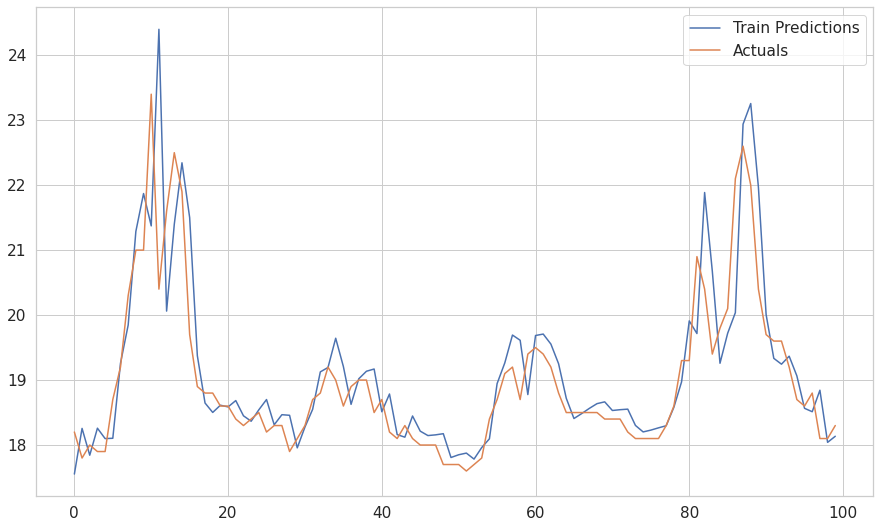




____________________________________________________________________________________________________
                                    LSTM Model - VALIDATION DATA                                    


      Val Predictions  Actuals
0           19.425297     19.6
1           20.207167     22.2
2           23.549000     24.2
3           25.413893     24.8
4           25.574602     23.4
...               ...      ...
8761        23.492325     24.0
8762        25.020760     22.8
8763        22.753113     21.6
8764        21.128990     24.6
8765        24.625574     24.5

[8766 rows x 2 columns]


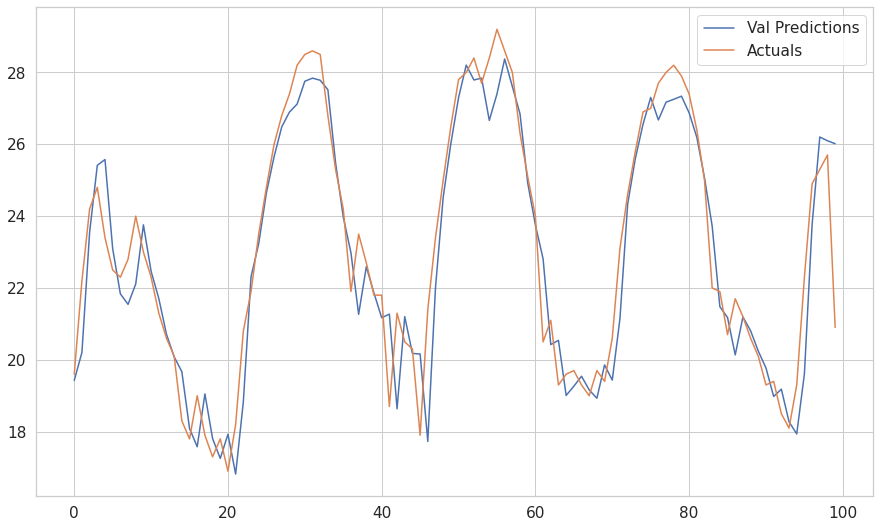




____________________________________________________________________________________________________
                                       LSTM Model - TEST DATA                                       


      Test Predictions  Actuals
0            24.063646     20.0
1            19.932194     22.3
2            21.867897     23.9
3            23.441359     23.9
4            23.679169     21.7
...                ...      ...
8761         27.068808     28.1
8762         26.879829     23.6
8763         22.878153     23.6
8764         22.545956     22.3
8765         21.403509     21.3

[8766 rows x 2 columns]


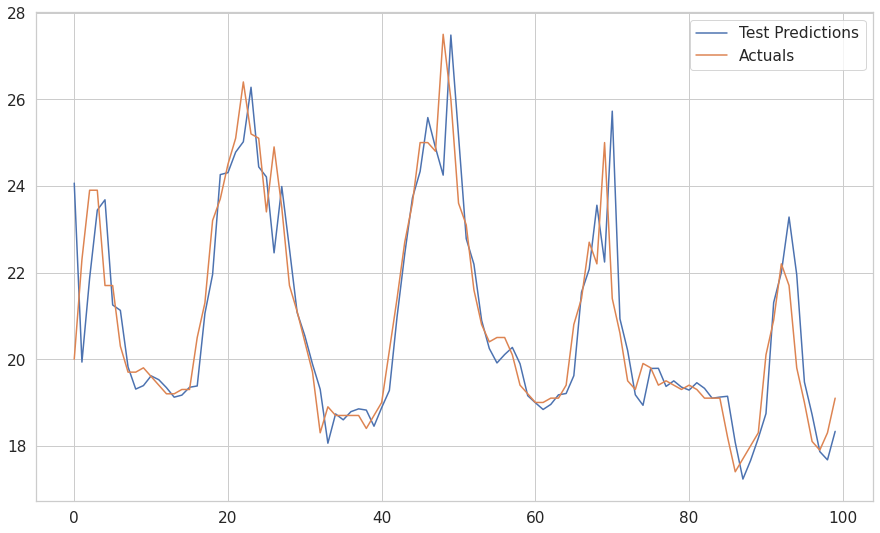

In [74]:
show_model(model1, X_train, y_train, X_val, y_val, X_test, y_test)

In [ ]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions1(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(y, predictions)

In [ ]:
def train_model_conv1d(X_train, y_train, X_val, y_val, model_name, epochs=10, learning_rate=0.0001):
  model = Sequential()
  model.add(InputLayer((5, 1)))
  model.add(Conv1D(64, kernel_size=2))
  model.add(Flatten())
  model.add(Dense(8, 'relu'))
  model.add(Dense(1, 'linear'))


  cp = ModelCheckpoint(f'{model_name}/', save_best_only=True)
  model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=learning_rate), metrics=[RootMeanSquaredError()])

  model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, callbacks=[cp])

  return model

In [ ]:
model2 = Sequential()
model2.add(InputLayer((5, 1)))
model2.add(Conv1D(64, kernel_size=2))
model2.add(Flatten())
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 4, 64)             192       
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 2056      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 2,257
Trainable params: 2,257
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cp2 = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp2])

Epoch 1/10
2192/2192 [==============================] - 5s 2ms/step - loss: 24.5832 - root_mean_squared_error: 4.9581 - val_loss: 2.5338 - val_root_mean_squared_error: 1.5918
INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


Epoch 2/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.7317 - root_mean_squared_error: 1.3159 - val_loss: 1.7263 - val_root_mean_squared_error: 1.3139
INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


Epoch 3/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.3685 - root_mean_squared_error: 1.1698 - val_loss: 1.4887 - val_root_mean_squared_error: 1.2201
INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


Epoch 4/10
2192/2192 [==============================] - 5s 2ms/step - loss: 1.2797 - root_mean_squared_error: 1.1312 - val_loss: 1.4392 - val_root_mean_squared_error: 1.1996
INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


Epoch 5/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2582 - root_mean_squared_error: 1.1217 - val_loss: 1.4408 - val_root_mean_squared_error: 1.2003
Epoch 6/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2498 - root_mean_squared_error: 1.1180 - val_loss: 1.4251 - val_root_mean_squared_error: 1.1938
INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


Epoch 7/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2485 - root_mean_squared_error: 1.1174 - val_loss: 1.4367 - val_root_mean_squared_error: 1.1986
Epoch 8/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2487 - root_mean_squared_error: 1.1174 - val_loss: 1.4534 - val_root_mean_squared_error: 1.2056
Epoch 9/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2468 - root_mean_squared_error: 1.1166 - val_loss: 1.4195 - val_root_mean_squared_error: 1.1914
INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


Epoch 10/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2446 - root_mean_squared_error: 1.1156 - val_loss: 1.4150 - val_root_mean_squared_error: 1.1895
INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


In [ ]:
model3 = Sequential()
model3.add(InputLayer((5, 1)))
model3.add(GRU(64))
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 64)                12864     
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 13,393
Trainable params: 13,393
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cp3 = ModelCheckpoint('model3/', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
model3.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp3])

Epoch 1/10
2192/2192 [==============================] - 15s 6ms/step - loss: 179.4865 - root_mean_squared_error: 13.3973 - val_loss: 14.4453 - val_root_mean_squared_error: 3.8007


INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


Epoch 2/10
2192/2192 [==============================] - 14s 6ms/step - loss: 4.0160 - root_mean_squared_error: 2.0040 - val_loss: 2.0650 - val_root_mean_squared_error: 1.4370


INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


Epoch 3/10
2192/2192 [==============================] - 12s 6ms/step - loss: 1.3666 - root_mean_squared_error: 1.1690 - val_loss: 1.4754 - val_root_mean_squared_error: 1.2147


INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


Epoch 4/10
2192/2192 [==============================] - 13s 6ms/step - loss: 1.2079 - root_mean_squared_error: 1.0990 - val_loss: 1.3975 - val_root_mean_squared_error: 1.1821


INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


Epoch 5/10
2192/2192 [==============================] - 13s 6ms/step - loss: 1.1684 - root_mean_squared_error: 1.0809 - val_loss: 1.3486 - val_root_mean_squared_error: 1.1613


INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


Epoch 6/10
2192/2192 [==============================] - 13s 6ms/step - loss: 1.1492 - root_mean_squared_error: 1.0720 - val_loss: 1.3305 - val_root_mean_squared_error: 1.1535


INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


Epoch 7/10
2192/2192 [==============================] - 13s 6ms/step - loss: 1.1418 - root_mean_squared_error: 1.0685 - val_loss: 1.3431 - val_root_mean_squared_error: 1.1589
Epoch 8/10
2192/2192 [==============================] - 13s 6ms/step - loss: 1.1371 - root_mean_squared_error: 1.0663 - val_loss: 1.3140 - val_root_mean_squared_error: 1.1463


INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


Epoch 9/10
2192/2192 [==============================] - 14s 6ms/step - loss: 1.1325 - root_mean_squared_error: 1.0642 - val_loss: 1.4001 - val_root_mean_squared_error: 1.1833
Epoch 10/10
2192/2192 [==============================] - 14s 6ms/step - loss: 1.1318 - root_mean_squared_error: 1.0639 - val_loss: 1.3094 - val_root_mean_squared_error: 1.1443


INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


In [ ]:
temp_df = pd.DataFrame({'Temperature':temperature_df})
temp_df['Seconds'] = temp_df.index.map(pd.Timestamp.timestamp)
temp_df

,Temperature,Seconds
datetime,,
2011-01-01 00:00:00,19.2,1.293840e+09
2011-01-01 01:00:00,19.3,1.293844e+09
2011-01-01 02:00:00,19.1,1.293847e+09
2011-01-01 03:00:00,18.1,1.293851e+09
2011-01-01 04:00:00,17.7,1.293854e+09
...,...,...
2020-12-31 19:00:00,28.1,1.609441e+09
2020-12-31 20:00:00,23.6,1.609445e+09
2020-12-31 21:00:00,23.6,1.609448e+09


In [ ]:
day = 60*60*24
year = 365.2425*day

temp_df['Day sin'] = np.sin(temp_df['Seconds'] * (2* np.pi / day))
temp_df['Day cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / day))
temp_df['Year sin'] = np.sin(temp_df['Seconds'] * (2 * np.pi / year))
temp_df['Year cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / year))
temp_df.head()

,Temperature,Seconds,Day sin,Day cos,Year sin,Year cos
datetime,,,,,,
2011-01-01 00:00:00,19.2,1.293840e+09,-7.057106e-12,1.000000,0.000989,1.000000
2011-01-01 01:00:00,19.3,1.293844e+09,2.588190e-01,0.965926,0.001706,0.999999
2011-01-01 02:00:00,19.1,1.293847e+09,5.000000e-01,0.866025,0.002423,0.999997
2011-01-01 03:00:00,18.1,1.293851e+09,7.071068e-01,0.707107,0.003140,0.999995
2011-01-01 04:00:00,17.7,1.293854e+09,8.660254e-01,0.500000,0.003856,0.999993


In [ ]:
temp_df = temp_df.drop('Seconds', axis=1)
temp_df.head()

,Temperature,Day sin,Day cos,Year sin,Year cos
datetime,,,,,
2011-01-01 00:00:00,19.2,-7.057106e-12,1.000000,0.000989,1.000000
2011-01-01 01:00:00,19.3,2.588190e-01,0.965926,0.001706,0.999999
2011-01-01 02:00:00,19.1,5.000000e-01,0.866025,0.002423,0.999997
2011-01-01 03:00:00,18.1,7.071068e-01,0.707107,0.003140,0.999995
2011-01-01 04:00:00,17.7,8.660254e-01,0.500000,0.003856,0.999993


In [ ]:
def df_to_X_y2(df, window_size=6):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
X2, y2 = df_to_X_y2(temp_df)
X2.shape, y2.shape

((87666, 6, 5), (87666,))

In [ ]:
total_len = len(X2)
test_val_len = int(total_len * 0.10)
train_len = total_len - (2*test_val_len)

In [ ]:
X2_train, y2_train = X2[:train_len], y2[:train_len]
X2_val, y2_val = X2[train_len:train_len + test_val_len], y2[train_len:train_len + test_val_len]
X2_test, y2_test = X2[train_len + test_val_len:], y2[train_len + test_val_len:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape

((70134, 6, 5), (70134,), (8766, 6, 5), (8766,), (8766, 6, 5), (8766,))

In [ ]:
temp_training_mean = np.mean(X2_train[:, :, 0])
temp_training_std = np.std(X2_train[:, :, 0])
                           
def preprocess(X):
  X[:, :, 0] = (X[:, :, 0] - temp_training_mean) / temp_training_std
  return X

In [ ]:
preprocess(X2_train)
preprocess(X2_val)
preprocess(X2_test)

array([[[ 2.46936515e-01,  1.27970306e-11, -1.00000000e+00,
          6.45099666e-03,  9.99979192e-01],
        [ 6.71751625e-01, -2.58819045e-01, -9.65925826e-01,
          7.16776241e-03,  9.99974311e-01],
        [ 3.53140293e-01, -5.00000000e-01, -8.66025404e-01,
          7.88452447e-03,  9.99968917e-01],
        [ 3.45289604e-02, -7.07106781e-01, -7.07106781e-01,
          8.60128248e-03,  9.99963008e-01],
        [ 8.31057292e-01, -8.66025404e-01, -5.00000000e-01,
          9.31803607e-03,  9.99956586e-01],
        [ 8.04506347e-01, -9.65925826e-01, -2.58819045e-01,
          1.00347849e-02,  9.99949650e-01]],

       [[ 6.71751625e-01, -2.58819045e-01, -9.65925826e-01,
          7.16776241e-03,  9.99974311e-01],
        [ 3.53140293e-01, -5.00000000e-01, -8.66025404e-01,
          7.88452447e-03,  9.99968917e-01],
        [ 3.45289604e-02, -7.07106781e-01, -7.07106781e-01,
          8.60128248e-03,  9.99963008e-01],
        [ 8.31057292e-01, -8.66025404e-01, -5.00000000e-01,
  

In [ ]:
model4 = Sequential()
model4.add(InputLayer((6, 5)))
model4.add(LSTM(64))
model4.add(Dense(8, 'relu'))
model4.add(Dense(1, 'linear'))

model4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cp4 = ModelCheckpoint('model4/', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
model4.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=10, callbacks=[cp4])

Epoch 1/10
2192/2192 [==============================] - 15s 6ms/step - loss: 120.1809 - root_mean_squared_error: 10.9627 - val_loss: 8.4859 - val_root_mean_squared_error: 2.9131


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


Epoch 2/10
2192/2192 [==============================] - 12s 5ms/step - loss: 3.6576 - root_mean_squared_error: 1.9125 - val_loss: 2.2826 - val_root_mean_squared_error: 1.5108


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


Epoch 3/10
2192/2192 [==============================] - 12s 5ms/step - loss: 1.4995 - root_mean_squared_error: 1.2245 - val_loss: 1.4702 - val_root_mean_squared_error: 1.2125


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


Epoch 4/10
2192/2192 [==============================] - 12s 5ms/step - loss: 1.1336 - root_mean_squared_error: 1.0647 - val_loss: 1.2061 - val_root_mean_squared_error: 1.0982


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


Epoch 5/10
2192/2192 [==============================] - 12s 6ms/step - loss: 0.9890 - root_mean_squared_error: 0.9945 - val_loss: 1.0948 - val_root_mean_squared_error: 1.0463


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


Epoch 6/10
2192/2192 [==============================] - 12s 5ms/step - loss: 0.9238 - root_mean_squared_error: 0.9612 - val_loss: 1.0515 - val_root_mean_squared_error: 1.0254


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


Epoch 7/10
2192/2192 [==============================] - 12s 5ms/step - loss: 0.8997 - root_mean_squared_error: 0.9485 - val_loss: 1.0325 - val_root_mean_squared_error: 1.0161


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


Epoch 8/10
2192/2192 [==============================] - 12s 6ms/step - loss: 0.8889 - root_mean_squared_error: 0.9428 - val_loss: 1.0198 - val_root_mean_squared_error: 1.0098


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


Epoch 9/10
2192/2192 [==============================] - 12s 5ms/step - loss: 0.8818 - root_mean_squared_error: 0.9390 - val_loss: 1.0183 - val_root_mean_squared_error: 1.0091


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


Epoch 10/10
2192/2192 [==============================] - 12s 6ms/step - loss: 0.8772 - root_mean_squared_error: 0.9366 - val_loss: 1.0208 - val_root_mean_squared_error: 1.0103


(      Predictions  Actuals
 0       24.061874     20.0
 1       20.012178     22.3
 2       21.832117     23.9
 3       22.881659     23.9
 4       22.639341     21.7
 ...           ...      ...
 8761    27.625896     28.1
 8762    27.081556     23.6
 8763    22.664391     23.6
 8764    22.704975     22.3
 8765    21.555908     21.3
 
 [8766 rows x 2 columns], 0.9134713960586293)

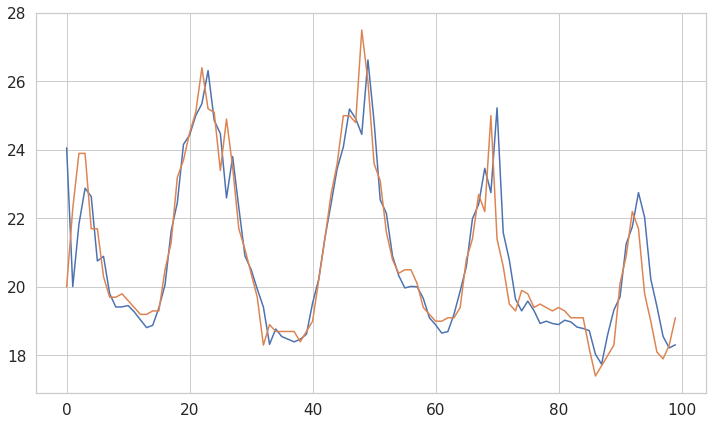

In [ ]:
plot_predictions1(model4, X2_test, y2_test)

In [ ]:
def train_model_conv1d(X_train, y_train, X_val, y_val, model_name, epochs=10, learning_rate=0.0001):
  model = Sequential()
  model.add(InputLayer((5, 1)))
  model.add(Conv1D(64, kernel_size=2))
  model.add(Flatten())
  model.add(Dense(8, 'relu'))
  model.add(Dense(1, 'linear'))


  cp = ModelCheckpoint(f'{model_name}/', save_best_only=True)
  model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=learning_rate), metrics=[RootMeanSquaredError()])

  model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, callbacks=[cp])

  return model

In [ ]:
%%time
test_model = train_model_conv1d(X_train1, y_train1, X_val1, y_val1, 'test_model', epochs=100)

Epoch 1/100
2192/2192 [==============================] - 4s 2ms/step - loss: 24.0584 - root_mean_squared_error: 4.9049 - val_loss: 2.9800 - val_root_mean_squared_error: 1.7263
INFO:tensorflow:Assets written to: test_model/assets


INFO:tensorflow:Assets written to: test_model/assets


Epoch 2/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.8432 - root_mean_squared_error: 1.3577 - val_loss: 1.6942 - val_root_mean_squared_error: 1.3016
INFO:tensorflow:Assets written to: test_model/assets


INFO:tensorflow:Assets written to: test_model/assets


Epoch 3/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.3689 - root_mean_squared_error: 1.1700 - val_loss: 1.4972 - val_root_mean_squared_error: 1.2236
INFO:tensorflow:Assets written to: test_model/assets


INFO:tensorflow:Assets written to: test_model/assets


Epoch 4/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2808 - root_mean_squared_error: 1.1317 - val_loss: 1.4551 - val_root_mean_squared_error: 1.2063
INFO:tensorflow:Assets written to: test_model/assets


INFO:tensorflow:Assets written to: test_model/assets


Epoch 5/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2590 - root_mean_squared_error: 1.1221 - val_loss: 1.4351 - val_root_mean_squared_error: 1.1980
INFO:tensorflow:Assets written to: test_model/assets


INFO:tensorflow:Assets written to: test_model/assets


Epoch 6/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2524 - root_mean_squared_error: 1.1191 - val_loss: 1.4277 - val_root_mean_squared_error: 1.1949
INFO:tensorflow:Assets written to: test_model/assets


INFO:tensorflow:Assets written to: test_model/assets


Epoch 7/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2497 - root_mean_squared_error: 1.1179 - val_loss: 1.4177 - val_root_mean_squared_error: 1.1907
INFO:tensorflow:Assets written to: test_model/assets


INFO:tensorflow:Assets written to: test_model/assets


Epoch 8/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2472 - root_mean_squared_error: 1.1168 - val_loss: 1.4254 - val_root_mean_squared_error: 1.1939
Epoch 9/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2490 - root_mean_squared_error: 1.1176 - val_loss: 1.4377 - val_root_mean_squared_error: 1.1990
Epoch 10/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2461 - root_mean_squared_error: 1.1163 - val_loss: 1.4228 - val_root_mean_squared_error: 1.1928
Epoch 11/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2473 - root_mean_squared_error: 1.1168 - val_loss: 1.4496 - val_root_mean_squared_error: 1.2040
Epoch 12/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2470 - root_mean_squared_error: 1.1167 - val_loss: 1.4221 - val_root_mean_squared_error: 1.1925
Epoch 13/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2459 - root_mean_squared_error: 1.1162 - v

INFO:tensorflow:Assets written to: test_model/assets


Epoch 15/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2462 - root_mean_squared_error: 1.1163 - val_loss: 1.4237 - val_root_mean_squared_error: 1.1932
Epoch 16/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2447 - root_mean_squared_error: 1.1157 - val_loss: 1.4292 - val_root_mean_squared_error: 1.1955
Epoch 17/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2445 - root_mean_squared_error: 1.1156 - val_loss: 1.4623 - val_root_mean_squared_error: 1.2092
Epoch 18/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2464 - root_mean_squared_error: 1.1164 - val_loss: 1.4158 - val_root_mean_squared_error: 1.1899
INFO:tensorflow:Assets written to: test_model/assets


INFO:tensorflow:Assets written to: test_model/assets


Epoch 19/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2448 - root_mean_squared_error: 1.1157 - val_loss: 1.4281 - val_root_mean_squared_error: 1.1950
Epoch 20/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2459 - root_mean_squared_error: 1.1162 - val_loss: 1.4333 - val_root_mean_squared_error: 1.1972
Epoch 21/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2495 - root_mean_squared_error: 1.1178 - val_loss: 1.4176 - val_root_mean_squared_error: 1.1906
Epoch 22/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2478 - root_mean_squared_error: 1.1171 - val_loss: 1.4273 - val_root_mean_squared_error: 1.1947
Epoch 23/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2475 - root_mean_squared_error: 1.1169 - val_loss: 1.4204 - val_root_mean_squared_error: 1.1918
Epoch 24/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2497 - root_mean_squared_error: 1.1179 -

INFO:tensorflow:Assets written to: test_model/assets


Epoch 33/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2462 - root_mean_squared_error: 1.1163 - val_loss: 1.4169 - val_root_mean_squared_error: 1.1904
Epoch 34/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2452 - root_mean_squared_error: 1.1159 - val_loss: 1.4385 - val_root_mean_squared_error: 1.1994
Epoch 35/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2451 - root_mean_squared_error: 1.1158 - val_loss: 1.4160 - val_root_mean_squared_error: 1.1900
Epoch 36/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2445 - root_mean_squared_error: 1.1156 - val_loss: 1.4923 - val_root_mean_squared_error: 1.2216
Epoch 37/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2488 - root_mean_squared_error: 1.1175 - val_loss: 1.4152 - val_root_mean_squared_error: 1.1896
INFO:tensorflow:Assets written to: test_model/assets


INFO:tensorflow:Assets written to: test_model/assets


Epoch 38/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2438 - root_mean_squared_error: 1.1153 - val_loss: 1.4153 - val_root_mean_squared_error: 1.1897
Epoch 39/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2438 - root_mean_squared_error: 1.1153 - val_loss: 1.4171 - val_root_mean_squared_error: 1.1904
Epoch 40/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2462 - root_mean_squared_error: 1.1163 - val_loss: 1.4231 - val_root_mean_squared_error: 1.1929
Epoch 41/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2439 - root_mean_squared_error: 1.1153 - val_loss: 1.4985 - val_root_mean_squared_error: 1.2241
Epoch 42/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2443 - root_mean_squared_error: 1.1155 - val_loss: 1.4282 - val_root_mean_squared_error: 1.1951
Epoch 43/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2457 - root_mean_squared_error: 1.1161 -

INFO:tensorflow:Assets written to: test_model/assets


Epoch 86/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2420 - root_mean_squared_error: 1.1145 - val_loss: 1.4148 - val_root_mean_squared_error: 1.1895
INFO:tensorflow:Assets written to: test_model/assets


INFO:tensorflow:Assets written to: test_model/assets


Epoch 87/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2417 - root_mean_squared_error: 1.1143 - val_loss: 1.4449 - val_root_mean_squared_error: 1.2020
Epoch 88/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2422 - root_mean_squared_error: 1.1146 - val_loss: 1.4164 - val_root_mean_squared_error: 1.1901
Epoch 89/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2431 - root_mean_squared_error: 1.1150 - val_loss: 1.4150 - val_root_mean_squared_error: 1.1895
Epoch 90/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2425 - root_mean_squared_error: 1.1147 - val_loss: 1.4355 - val_root_mean_squared_error: 1.1981
Epoch 91/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2440 - root_mean_squared_error: 1.1154 - val_loss: 1.4170 - val_root_mean_squared_error: 1.1904
Epoch 92/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2435 - root_mean_squared_error: 1.1151 -

INFO:tensorflow:Assets written to: test_model/assets


Epoch 96/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2405 - root_mean_squared_error: 1.1138 - val_loss: 1.4608 - val_root_mean_squared_error: 1.2086
Epoch 97/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2409 - root_mean_squared_error: 1.1140 - val_loss: 1.4169 - val_root_mean_squared_error: 1.1903
Epoch 98/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2419 - root_mean_squared_error: 1.1144 - val_loss: 1.4174 - val_root_mean_squared_error: 1.1905
Epoch 99/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2427 - root_mean_squared_error: 1.1147 - val_loss: 1.4205 - val_root_mean_squared_error: 1.1918
Epoch 100/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2421 - root_mean_squared_error: 1.1145 - val_loss: 1.4212 - val_root_mean_squared_error: 1.1921
CPU times: user 7min 28s, sys: 40.9 s, total: 8min 9s
Wall time: 6min 22s


(      Predictions  Actuals
 0       24.364063     20.0
 1       19.244774     22.3
 2       22.198639     23.9
 3       23.798664     23.9
 4       23.748337     21.7
 ...           ...      ...
 8761    27.348679     28.1
 8762    27.133282     23.6
 8763    21.978630     23.6
 8764    22.410475     22.3
 8765    21.173981     21.3
 
 [8766 rows x 2 columns], 1.2813420195246468)

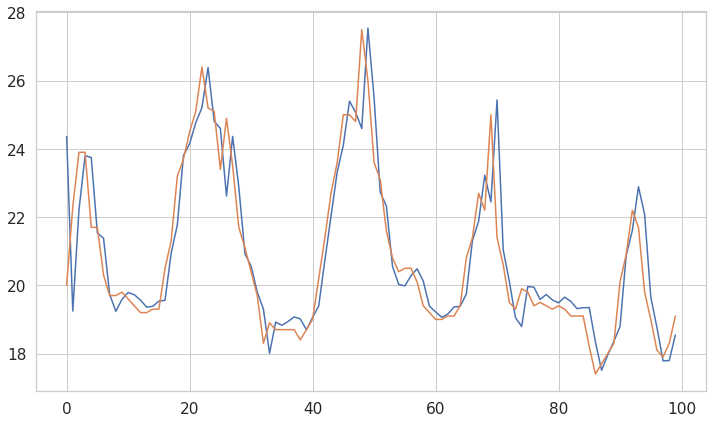

In [ ]:
plot_predictions1(test_model, X_test1, y_test1)

### SKEWNESS and KURTOSIS

In [ ]:
from scipy.stats import kurtosis
from statistics import mean, mode, median
import statsmodels.api as sma
from statsmodels.stats.outliers_influence import variance_inflation_factor

from matplotlib import ticker

# Calculating coefficient of skewness ( Pearson's second coefficient of skewness )
skewness = (3 * (df['Temperature'].mean() - df['Temperature'].median())) / df['Temperature'].std()

print(f"Skewness: {round(skewness, 2)}")
print(f'Kurtosis: {round(kurtosis(df.Temperature), 2)}')

ax = sns.histplot(data=df, x='Temperature', kde=True)
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f} °C'))
plt.xticks(rotation=60)
plt.show()


# Calculating coefficient of skewness with log transformation ( Pearson's second coefficient of skewness )
df_log = np.log(df['Temperature'])
skewness_log = (3 * (df_log.mean() - df_log.median())) / df_log.std()

print(f"Skewness: {round(skewness_log, 2)}")
print(f'Kurtosis: {kurtosis(np.log(df["Temperature"]))}')
sns.histplot(data=df, x=np.log(df["Temperature"]), kde=True)
plt.xlabel('Temperature (Log Scale)')
plt.show()